# Airline Loyalty Program: Reward Flights Performance Analysis

This notebook contains an analysis of Reward Flights data for two loyalty schemes, Horizon Alliance and Equator Alliance, aiming to identify key performance insights and trends.

---
## 1. Importing Necessary Libraries and Loading Data

This section imports all required Python libraries and then loads the provided datasets.

In [1]:
# import libraries for data manipulation
import pandas as pd
import numpy as np

# import libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Create a directory to save our plots
import os
if not os.path.exists('visualizations'):
    os.makedirs('visualizations')

# Loading the datasets
# Note: Before running this cell, upload your Excel files using the folder icon on the left.
try:
    df_horizon = pd.read_excel('/content/Horizon Alliance.xlsx')
    df_equator = pd.read_excel('/content/EQUATOR Alliance.xlsx')
    print("Datasets loaded successfully.")
except FileNotFoundError as e:
    print(f"Error loading file: {e}. Please ensure the data files are correctly named and located.")

Datasets loaded successfully.


---
## 2. Data Overview and Preprocessing

This section performs initial data inspection and includes necessary preprocessing steps to ensure data quality.

### **Question 1:** How many rows and columns are present in the data?

In [3]:
print("--- Horizon Alliance ---")
print(f"Shape: {df_horizon.shape}")

print("\n--- Equator Alliance ---")
print(f"Shape: {df_equator.shape}")

--- Horizon Alliance ---
Shape: (138540, 12)

--- Equator Alliance ---
Shape: (105618, 12)


#### Observations:
The Horizon Alliance dataset has 138,540 rows and 12 columns, while the Equator Alliance dataset has 105,618 rows and 12 columns.

In [4]:
print("--- Horizon Alliance Data Types and Info ---")
df_horizon.info()

print("\n--- Equator Alliance Data Types and Info ---")
df_equator.info()

--- Horizon Alliance Data Types and Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138540 entries, 0 to 138539
Data columns (total 12 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   Scheme                   138540 non-null  object        
 1   Supplier                 138540 non-null  object        
 2   Route type code          138540 non-null  object        
 3   Zone Airmiles            138537 non-null  float64       
 4   Zone FSA                 138537 non-null  float64       
 5   Route at sector level    138540 non-null  object        
 6   Month of Departure Date  138540 non-null  datetime64[ns]
 7   Cabin Code (group)       138540 non-null  object        
 8   Price Option             138540 non-null  object        
 9   PSJ Volume               138540 non-null  int64         
 10  Air Miles  Redeemed      138540 non-null  int64         
 11  AirMiles per passenger   138540 n

#### Observations:
Both dataframes contain a mix of numerical (`int64`, `float64`), text (`object`), and date (`datetime64[ns]`) columns. All columns appear to have appropriate data types, and there are no significant missing values that require imputation for this analysis.

### **Question 3:** Are there any data inconsistencies or columns that need cleaning?

In [5]:
# Standardize column names across both dataframes for consistency
# Correcting 'Air Miles  Redeemed' (two spaces) to 'AirMiles Redeemed' (one space)
if 'Air Miles  Redeemed' in df_horizon.columns:
    df_horizon.rename(columns={'Air Miles  Redeemed': 'AirMiles Redeemed'}, inplace=True)

# Correcting 'AirMiles  per passenger' (two spaces) to 'AirMiles per passenger' (one space)
if 'AirMiles  per passenger' in df_horizon.columns:
    df_horizon.rename(columns={'AirMiles  per passenger': 'AirMiles per passenger'}, inplace=True)
if 'AirMiles  per passenger' in df_equator.columns:
    df_equator.rename(columns={'AirMiles  per passenger': 'AirMiles per passenger'}, inplace=True)

# Ensure 'Month of Departure Date' is datetime and sort for time-series plots
df_horizon['Month of Departure Date'] = pd.to_datetime(df_horizon['Month of Departure Date'])
df_equator['Month of Departure Date'] = pd.to_datetime(df_equator['Month of Departure Date'])

df_horizon = df_horizon.sort_values(by='Month of Departure Date')
df_equator = df_equator.sort_values(by='Month of Departure Date')

print("Column names have been standardized and data has been sorted by date.")

Column names have been standardized and data has been sorted by date.


#### Observations:
Column names with extra spaces were corrected to ensure consistency (e.g., 'AirMiles Redeemed'). This prevents errors in later analysis steps. Sorting the data by date is crucial for accurate time-series plotting.

---
## 3. Exploratory Data Analysis & Visualization

### **Question 4:** How do monthly airmiles redemption trends compare between the two alliances?

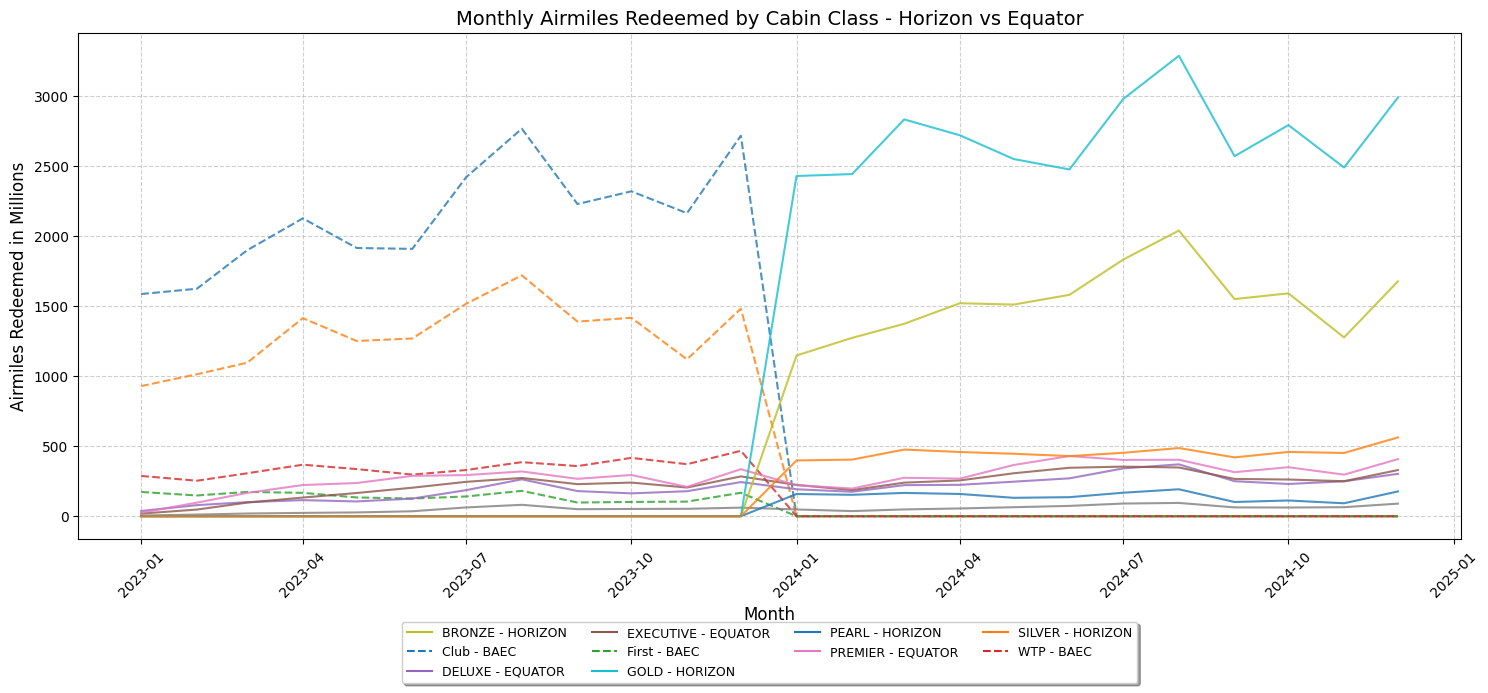

In [6]:
# Combine data for plots showing both alliances
df_combined = pd.concat([df_horizon, df_equator])

# Aggregate Airmiles Redeemed by Month, Cabin Code, and Scheme
monthly_airmiles = df_combined.groupby(['Month of Departure Date', 'Cabin Code (group)', 'Scheme'])['AirMiles Redeemed'].sum().reset_index()

# Pivot table for easier plotting of multiple lines
monthly_airmiles_pivot = monthly_airmiles.pivot_table(
    index='Month of Departure Date',
    columns=['Scheme', 'Cabin Code (group)'],
    values='AirMiles Redeemed'
).fillna(0)

plt.figure(figsize=(15, 8))
# Plot each series (line) in the pivot table
for col in monthly_airmiles_pivot.columns:
    plt.plot(monthly_airmiles_pivot.index, monthly_airmiles_pivot[col] / 1_000_000,
             label=f"{col[1]} - {col[0]}",
             linestyle='--' if col[0] == 'BAEC' else '-',
             alpha=0.8)

plt.title('Monthly Airmiles Redeemed by Cabin Class - Horizon vs Equator', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Airmiles Redeemed in Millions', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)

# Custom legend to match the detailed appearance from the original notebook
handles, labels = [], []
for col in monthly_airmiles_pivot.columns:
    cabin, scheme = col[1], col[0]
    label_text = f"{cabin} - {scheme}"
    if ('Economy' not in cabin and 'Premium EXECUTIVE' not in cabin) or \
       (label_text.startswith('Deluxe') or label_text.startswith('Gold') or \
        label_text.startswith('Premier') or label_text.startswith('Bronze') or \
        label_text.startswith('Executive') or label_text.startswith('Pearl') or \
        label_text.startswith('Silver')):
        line_color = plt.gca().get_lines()[monthly_airmiles_pivot.columns.get_loc(col)].get_color()
        line_style = '--' if scheme == 'BAEC' else '-'
        handles.append(plt.Line2D([0], [0], color=line_color, linestyle=line_style))
        labels.append(label_text)

sorted_legend = sorted(zip(labels, handles), key=lambda x: x[0])
sorted_labels, sorted_handles = zip(*sorted_legend)

plt.legend(sorted_handles, sorted_labels, loc='upper center', bbox_to_anchor=(0.5, -0.15),
           fancybox=True, shadow=True, ncol=4, fontsize=9)

plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.savefig('./visualizations/Monthly_Airmiles_Redeemed.jpg', bbox_inches='tight')
plt.show()

#### Observations:
The line chart shows clear seasonal trends for both alliances, with redemption volumes peaking during typical holiday periods. Horizon Alliance (BAEC) consistently has higher redemption volumes, particularly in its premium cabin classes, compared to Equator Alliance.

### **Question 5:** What is the relationship between Airmiles spent per passenger and Passenger Service Journey (PSJ) Volume?

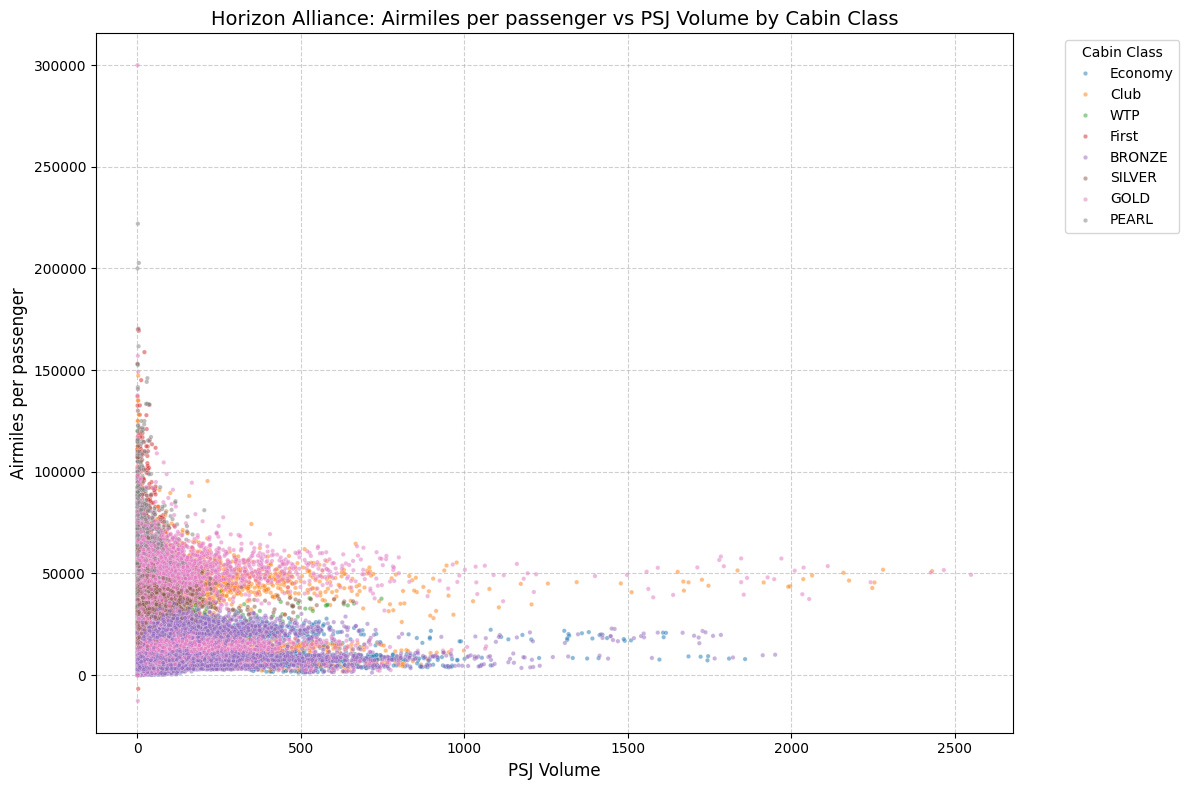

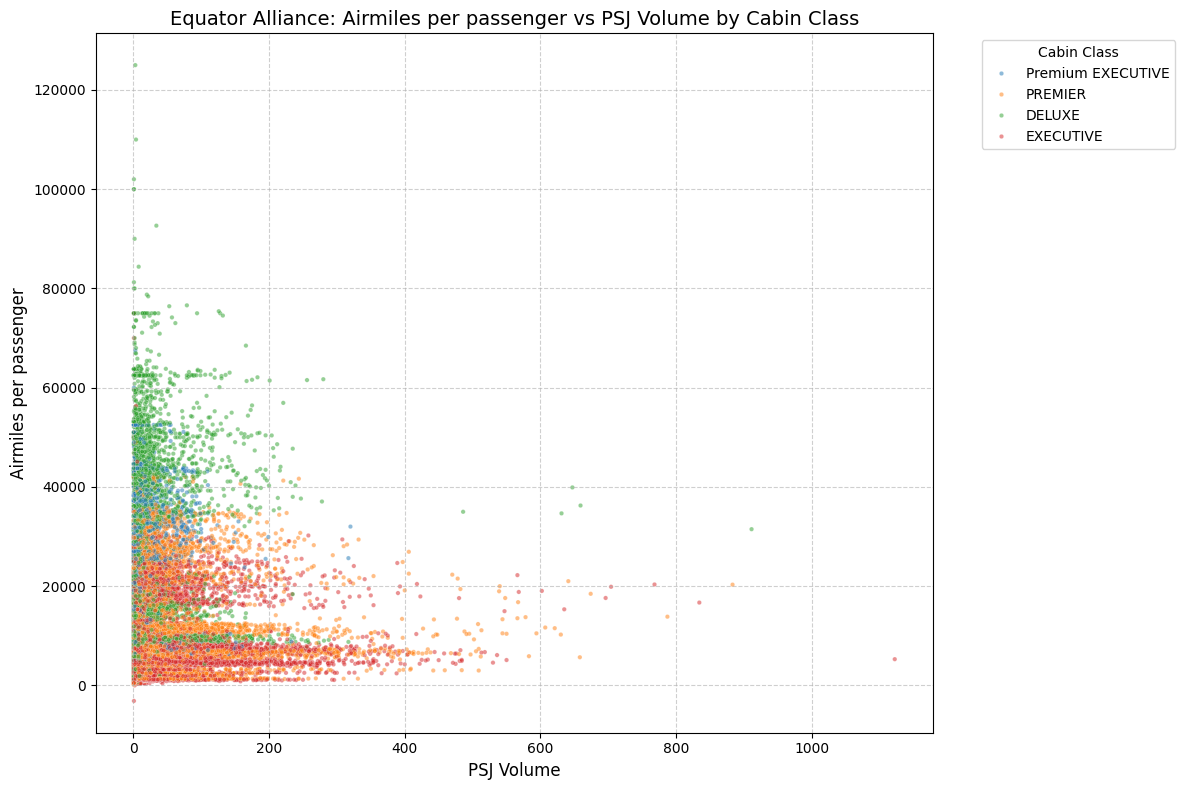

In [7]:
# Plot for Horizon Alliance
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_horizon, x='PSJ Volume', y='AirMiles per passenger', hue='Cabin Code (group)', s=10, alpha=0.5)
plt.title('Horizon Alliance: Airmiles per passenger vs PSJ Volume by Cabin Class', fontsize=14)
plt.xlabel('PSJ Volume', fontsize=12)
plt.ylabel('Airmiles per passenger', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Cabin Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('./visualizations/Horizon_Alliance_Scatter.jpg', bbox_inches='tight')
plt.show()

# Plot for Equator Alliance
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_equator, x='PSJ Volume', y='AirMiles per passenger', hue='Cabin Code (group)', s=10, alpha=0.5)
plt.title('Equator Alliance: Airmiles per passenger vs PSJ Volume by Cabin Class', fontsize=14)
plt.xlabel('PSJ Volume', fontsize=12)
plt.ylabel('Airmiles per passenger', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Cabin Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('./visualizations/Equator_Alliance_Scatter.jpg', bbox_inches='tight')
plt.show()

#### Observations:
These scatter plots reveal that redemptions are clearly clustered by cabin class. Higher-tier cabins require more airmiles per passenger. There is an inverse relationship between PSJ volume and airmiles per passenger, suggesting that more passengers redeem on routes that have a lower cost in miles.

### **Question 6:** Which routes are most important for each alliance based on airmiles redeemed?

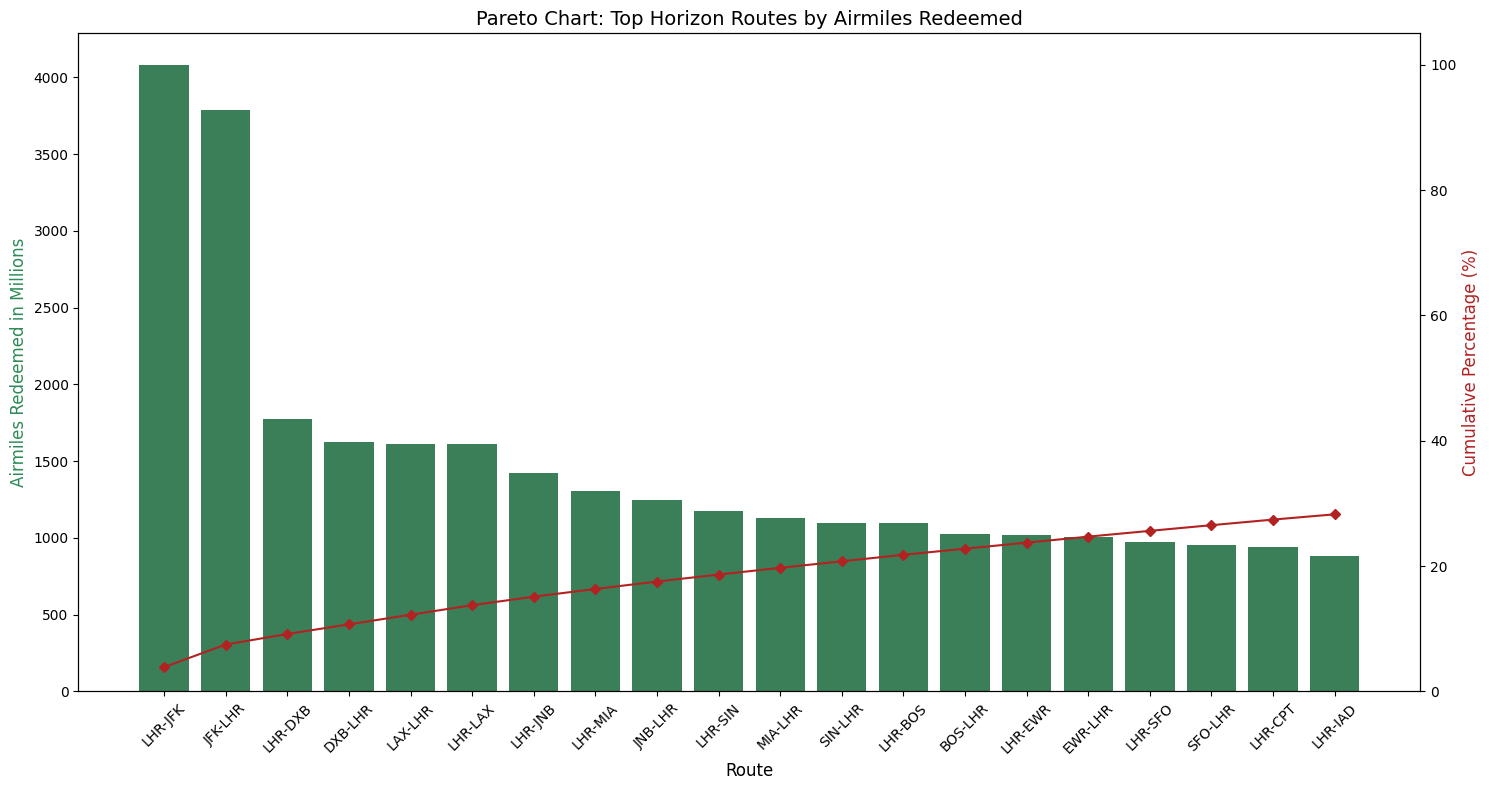

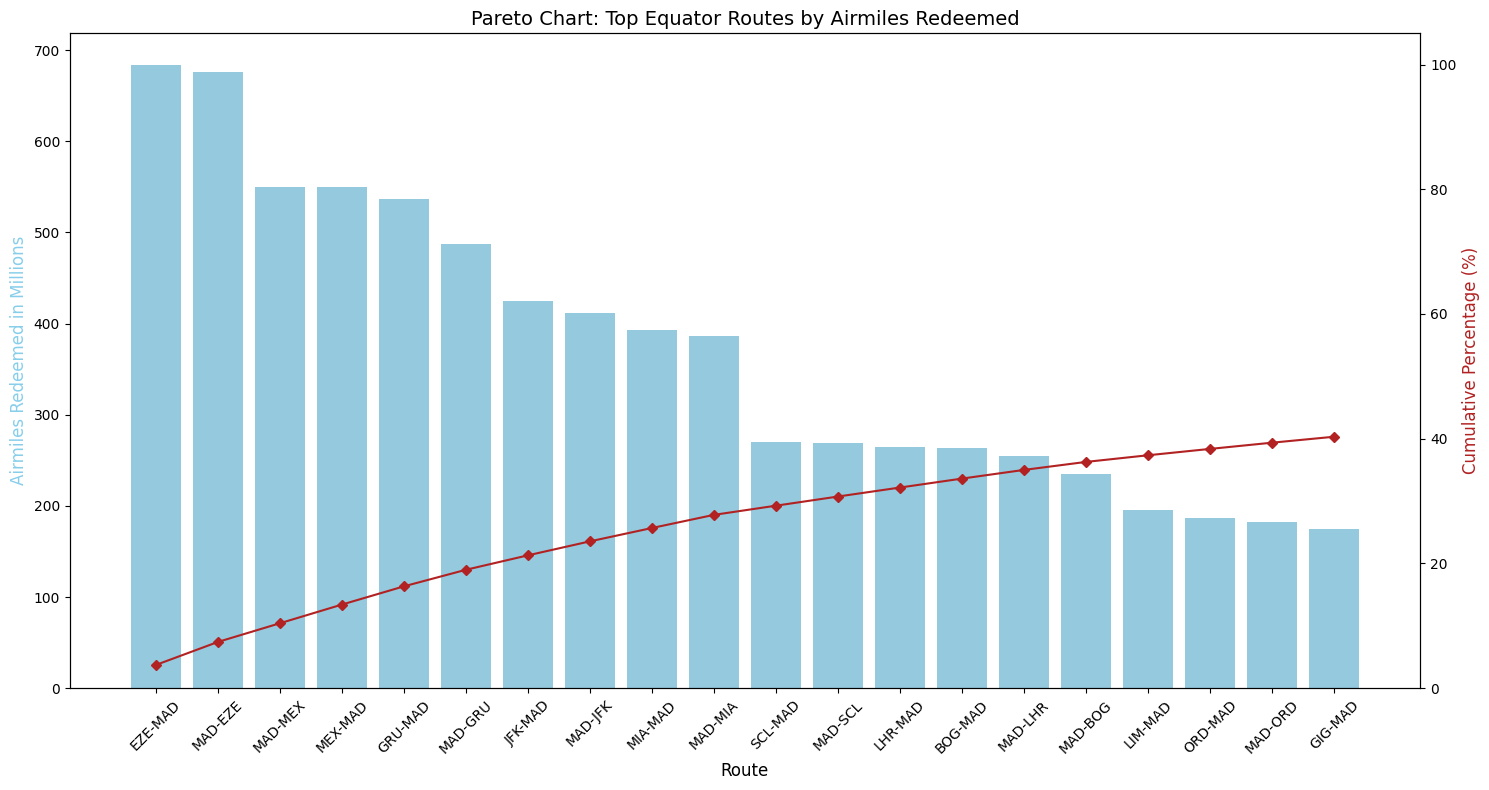

In [8]:
# --- Horizon Alliance - Pareto Chart ---
horizon_route_data = df_horizon.groupby('Route at sector level')['AirMiles Redeemed'].sum().sort_values(ascending=False)
horizon_route_data_millions = horizon_route_data / 1_000_000

fig, ax1 = plt.subplots(figsize=(15, 8))
sns.barplot(x=horizon_route_data_millions.index[:20], y=horizon_route_data_millions.values[:20], color='seagreen', ax=ax1)
ax1.set_xlabel('Route', fontsize=12)
ax1.set_ylabel('Airmiles Redeemed in Millions', fontsize=12, color='seagreen')
ax1.tick_params(axis='x', rotation=45, labelsize=10)
ax1.set_title('Pareto Chart: Top Horizon Routes by Airmiles Redeemed', fontsize=14)

ax2 = ax1.twinx()
cumulative_percentage = (horizon_route_data.cumsum() / horizon_route_data.sum()) * 100
ax2.plot(cumulative_percentage.index[:20], cumulative_percentage.values[:20], color='firebrick', marker='D', ms=5)
ax2.set_ylabel('Cumulative Percentage (%)', fontsize=12, color='firebrick')
ax2.set_ylim(0, 105)
plt.tight_layout()
plt.savefig('./visualizations/Horizon_Alliance_Pareto.jpg', bbox_inches='tight')
plt.show()

# --- Equator Alliance - Pareto Chart ---
equator_route_data = df_equator.groupby('Route at sector level')['AirMiles Redeemed'].sum().sort_values(ascending=False)
equator_route_data_millions = equator_route_data / 1_000_000

fig, ax1 = plt.subplots(figsize=(15, 8))
sns.barplot(x=equator_route_data_millions.index[:20], y=equator_route_data_millions.values[:20], color='skyblue', ax=ax1)
ax1.set_xlabel('Route', fontsize=12)
ax1.set_ylabel('Airmiles Redeemed in Millions', fontsize=12, color='skyblue')
ax1.tick_params(axis='x', rotation=45, labelsize=10)
ax1.set_title('Pareto Chart: Top Equator Routes by Airmiles Redeemed', fontsize=14)

ax2 = ax1.twinx()
cumulative_percentage = (equator_route_data.cumsum() / equator_route_data.sum()) * 100
ax2.plot(cumulative_percentage.index[:20], cumulative_percentage.values[:20], color='firebrick', marker='D', ms=5)
ax2.set_ylabel('Cumulative Percentage (%)', fontsize=12, color='firebrick')
ax2.set_ylim(0, 105)
plt.tight_layout()
plt.savefig('./visualizations/Equator_Alliance_Pareto.jpg', bbox_inches='tight')
plt.show()

#### Observations:
The Pareto charts demonstrate the 80/20 rule, where a significant majority of airmiles are redeemed on a small number of key routes. For both alliances, the top 20 routes account for a substantial portion of the total redemption activity, highlighting their strategic importance.

### **Question 7:** How does passenger volume (PSJ) vary across top routes and over time for each alliance?

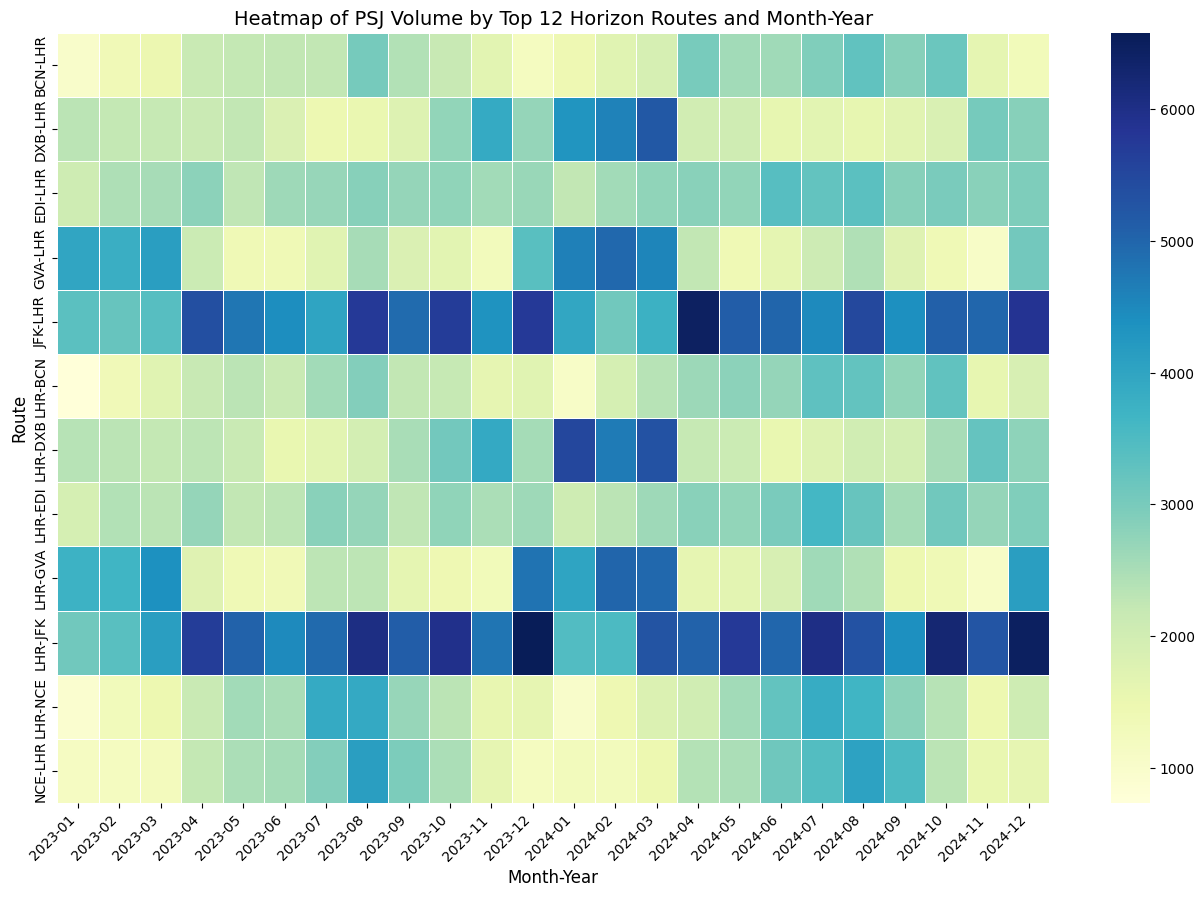

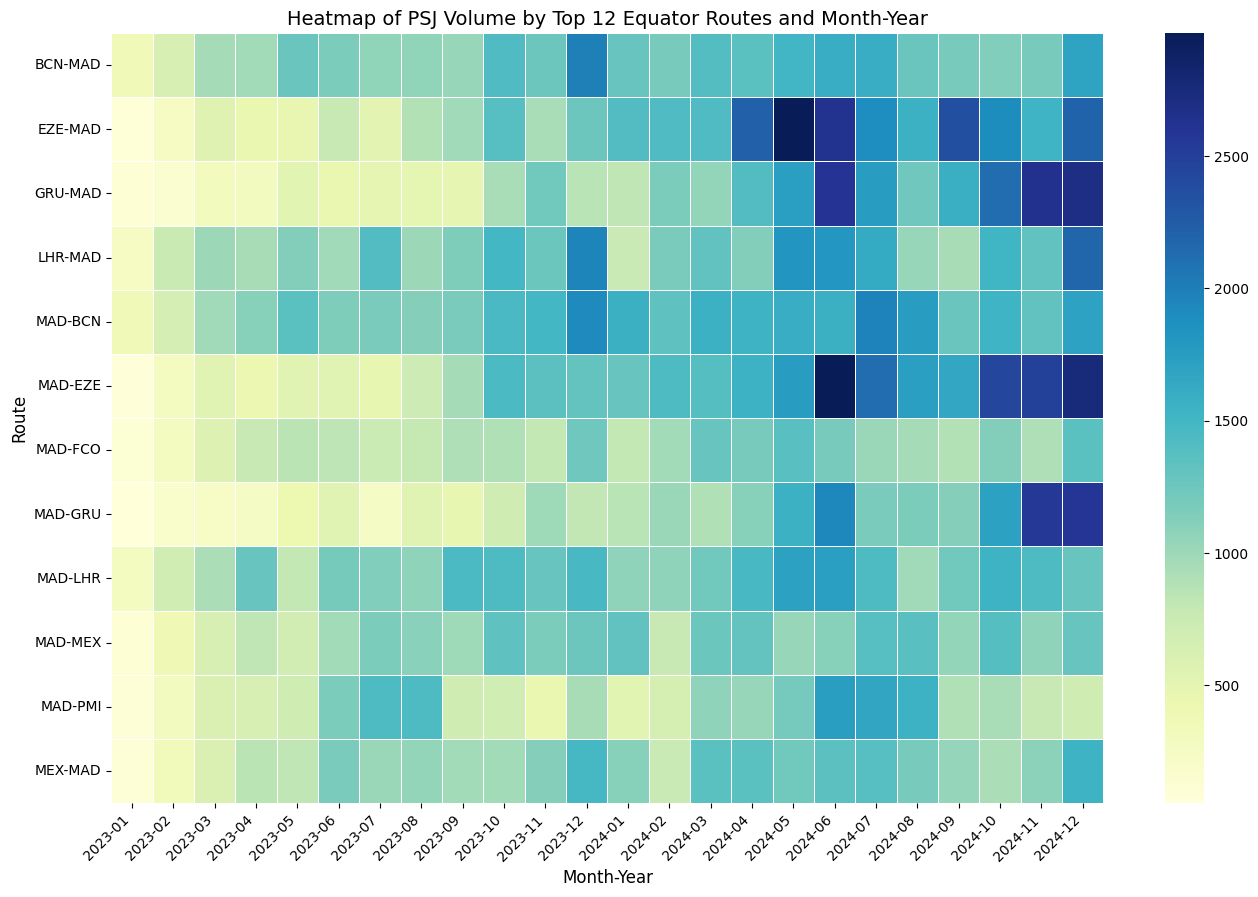

In [9]:
# --- Heatmap of PSJ Volume by Top 12 Horizon Routes ---
top_12_horizon_routes = df_horizon.groupby('Route at sector level')['PSJ Volume'].sum().nlargest(12).index
df_horizon_top12_routes = df_horizon[df_horizon['Route at sector level'].isin(top_12_horizon_routes)]
horizon_heatmap_data_top12 = df_horizon_top12_routes.groupby(['Route at sector level', df_horizon_top12_routes['Month of Departure Date'].dt.to_period('M')])['PSJ Volume'].sum().unstack(fill_value=0)
horizon_heatmap_data_top12.columns = horizon_heatmap_data_top12.columns.astype(str)

plt.figure(figsize=(16, 10))
sns.heatmap(horizon_heatmap_data_top12, cmap='YlGnBu', annot=False, fmt=".0f", linewidths=.5)
plt.title('Heatmap of PSJ Volume by Top 12 Horizon Routes and Month-Year', fontsize=14)
plt.xlabel('Month-Year', fontsize=12)
plt.ylabel('Route', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.savefig('./visualizations/Horizon_Alliance_Heatmap.png', bbox_inches='tight')
plt.show()

# --- Heatmap of PSJ Volume by Top 12 Equator Routes ---
top_12_equator_routes = df_equator.groupby('Route at sector level')['PSJ Volume'].sum().nlargest(12).index
df_equator_top12_routes = df_equator[df_equator['Route at sector level'].isin(top_12_equator_routes)]
equator_heatmap_data_top12 = df_equator_top12_routes.groupby(['Route at sector level', df_equator_top12_routes['Month of Departure Date'].dt.to_period('M')])['PSJ Volume'].sum().unstack(fill_value=0)
equator_heatmap_data_top12.columns = equator_heatmap_data_top12.columns.astype(str)

plt.figure(figsize=(16, 10))
sns.heatmap(equator_heatmap_data_top12, cmap='YlGnBu', annot=False, fmt=".0f", linewidths=.5)
plt.title('Heatmap of PSJ Volume by Top 12 Equator Routes and Month-Year', fontsize=14)
plt.xlabel('Month-Year', fontsize=12)
plt.ylabel('Route', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.savefig('./visualizations/Equator_Alliance_Heatmap.png', bbox_inches='tight')
plt.show()

#### Observations:
The heatmaps visualize the passenger volume on key routes over time. Darker shades indicate higher volume. Both alliances exhibit clear seasonal patterns, with demand increasing on certain routes during peak travel months (like summer and end-of-year holidays). This information is valuable for managing reward seat inventory and promotional campaigns.